In [1]:
import sys
print(sys.version)
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
sns.set_style("dark")
sns.set_palette(sns.color_palette("BuGn_r"))
import statsmodels.api as sm

from datetime import datetime

import scipy.stats as stats

sys.path.append("../data_proc")

import data_proc.rpna_processing as utils

# import pandas_profiling

3.7.3 (default, Dec 13 2019, 19:58:14) 
[Clang 11.0.0 (clang-1100.0.33.17)]


In [2]:
# Load crude oil dataset
df_oil = pd.read_csv("../data/ravenpack/crude_oil_all.csv")

In [3]:
df_oil.head()

,TIMESTAMP_UTC,RPNA_DATE_UTC,RPNA_TIME_UTC,RP_ENTITY_ID,ENTITY_TYPE,ENTITY_NAME,POSITION_NAME,RP_POSITION_ID,COUNTRY_CODE,RELEVANCE,...,G_ENS_SIMILARITY_GAP,G_ENS_KEY,G_ENS_ELAPSED,EVENT_SIMILARITY_KEY,NEWS_TYPE,SOURCE,RP_STORY_ID,RP_STORY_EVENT_INDEX,RP_STORY_EVENT_COUNT,PRODUCT_KEY
0,2000-01-01 10:08:00.000,20000101,10:08:00.000,FD9CFE,CMDT,Crude Oil,NaN,NaN,XX,100,...,0.00000,765AA7AB5BF56293D1849B82B14533BB,0,4E59863BBB2CB48F58809D319047702A,NEWS-FLASH,B5569E,3F3083D8BBC9731C0F37EBA7F1AB3192,2,2,DJ-GM
1,2000-01-01 10:08:00.000,20000101,10:08:00.000,FD9CFE,CMDT,Crude Oil,NaN,NaN,XX,100,...,0.00000,765AA7AB5BF56293D1849B82B14533BB,0,4E59863BBB2CB48F58809D319047702A,NEWS-FLASH,B5569E,765AA7AB5BF56293D1849B82B14533BB,2,2,DJ-GM
2,2000-01-03 07:00:00.000,20000103,07:00:00.000,FD9CFE,CMDT,Crude Oil,NaN,NaN,XX,100,...,5.02083,183E1A9B074070F5E794483D4DFE66FA,0,6A5CE8F078AA1954083E870CA70828F9,FULL-ARTICLE,18A55F,183E1A9B074070F5E794483D4DFE66FA,1,1,DJ-GM
3,2000-01-04 05:00:00.000,20000104,05:00:00.000,FD9CFE,CMDT,Crude Oil,NaN,NaN,XX,100,...,0.91667,183E1A9B074070F5E794483D4DFE66FA,79200000,6A5CE8F078AA1954083E870CA70828F9,FULL-ARTICLE,18A55F,C16D093C381A7FF580D438CF66F41779,1,1,DJ-GM
4,2000-01-04 07:46:00.000,20000104,07:46:00.000,FD9CFE,CMDT,Crude Oil,NaN,NaN,XX,100,...,42.19375,637F73A1EEB28EFDA918BA130E4BE237,0,510BBC6D3AF663EFB6A0B84717A44ED3,NEWS-FLASH,B5569E,637F73A1EEB28EFDA918BA130E4BE237,1,1,DJ-GM


In [4]:
for c in [
    "ENTITY_TYPE", "ENTITY_NAME", "POSITION_NAME",
    "SUB_TYPE", "PROPERTY", "RELEVANCE"
]:
    print("===========================")
    print(df_oil[c].value_counts())

CMDT    106960
Name: ENTITY_TYPE, dtype: int64
Crude Oil    106960
Name: ENTITY_NAME, dtype: int64
Series([], Name: POSITION_NAME, dtype: int64)
loss          39293
gain          34541
increase       8422
decrease       7050
up             4345
down           3329
buy            1171
unchanged       453
offer           429
upgrade         353
sell            303
downgrade       261
resistance      150
lifted           97
attack           32
suspended         8
set               7
close             6
open              5
contained         4
sale              3
threat            1
support           1
released          1
ended             1
Name: SUB_TYPE, dtype: int64
commodity           17863
target               1903
bearish              1322
bullish               194
oversold               85
output                 35
overbought             16
target-commodity        4
Name: PROPERTY, dtype: int64
100    106960
Name: RELEVANCE, dtype: int64


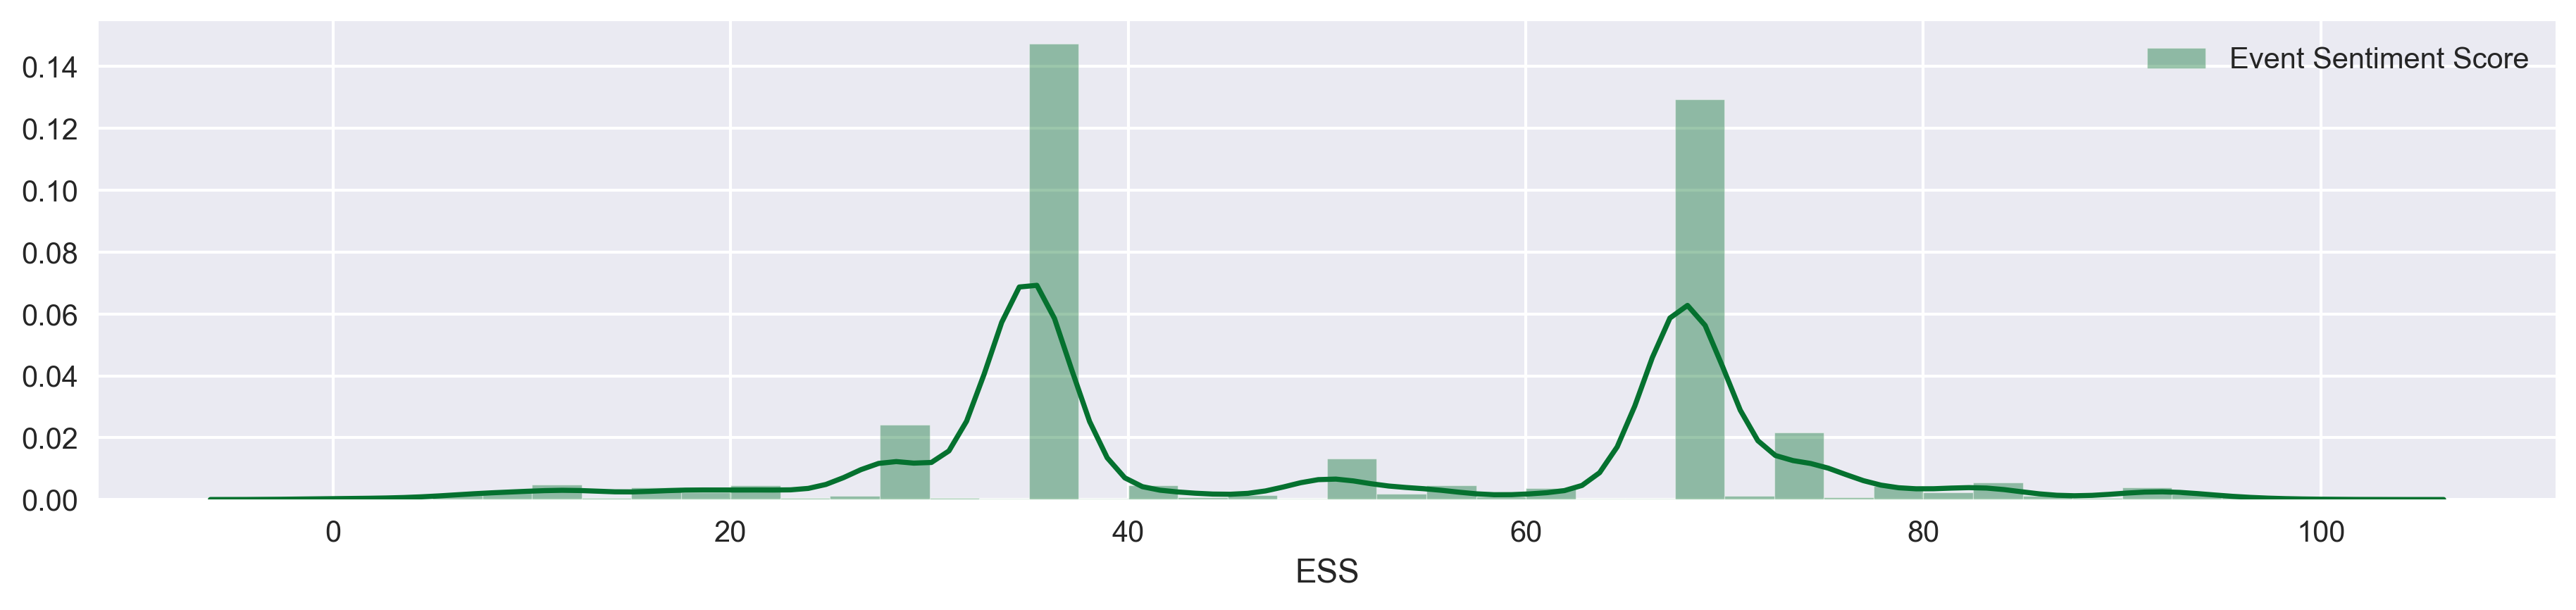

In [5]:
plt.rcParams["figure.figsize"] = (15, 3)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True
sns.distplot(df_oil.ESS, bins=40, kde=True, label="Event Sentiment Score")
plt.legend()
plt.show()

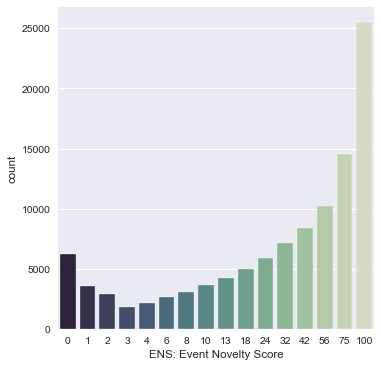

In [6]:
plt.rcParams["figure.dpi"] = 75
color = sns.cubehelix_palette(16, start=.5, rot=-.75, reverse=True)
chart = sns.catplot(x="ENS", kind="count", data=df_oil, palette=color)
chart.set_xlabels("ENS: Event Novelty Score")
chart.savefig("eda_figures/crude_oil/{}.png".format("ENS"))
plt.show()

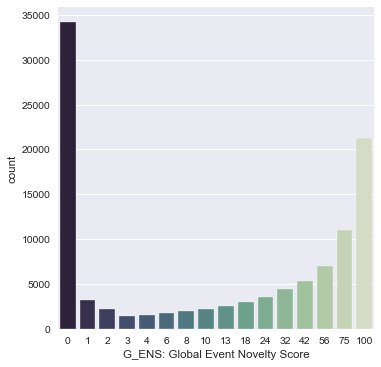

In [7]:
chart = sns.catplot(x="G_ENS", kind="count", data=df_oil, palette=color)
chart.set_xlabels("G_ENS: Global Event Novelty Score")
chart.savefig("eda_figures/crude_oil/{}.png".format("G_ENS"))
plt.show()

In [11]:
# up sample (aggregate) to daily level.
daily = utils.preprocessing(df_oil, threshold=(0, 0))
daily = daily.asfreq("B")

Percentage same:  90.86 % 


In [12]:
daily.head()

,ESS_MEAN,ESS_TOTAL,WESS_MEAN,WESS_TOTAL,NUM_EVENTS,NUM_POSITIVE_ESS,NUM_NEGATIVE_ESS,NUM_NEUTRAL_ESS,NUM_POSITIVE_WESS,NUM_NEGATIVE_WESS,NUM_NEUTRAL_WESS
DATE,,,,,,,,,,,
2000-01-03,18.0,36.0,15.7500,31.50,2.0,2.0,0.0,0.0,2.0,0.0,0.0
2000-01-04,5.0,30.0,3.5550,21.33,6.0,3.0,2.0,1.0,3.0,2.0,1.0
2000-01-05,-6.0,-12.0,-6.0000,-12.00,2.0,1.0,1.0,0.0,1.0,1.0,0.0
2000-01-06,-26.5,-53.0,-26.5000,-53.00,2.0,0.0,2.0,0.0,0.0,2.0,0.0
2000-01-07,-15.0,-60.0,-10.7625,-43.05,4.0,0.0,4.0,0.0,0.0,4.0,0.0


In [21]:
daily[daily["NUM_EVENTS"].isnull()]

,ESS_MEAN,ESS_TOTAL,WESS_MEAN,WESS_TOTAL,NUM_EVENTS,NUM_POSITIVE_ESS,NUM_NEGATIVE_ESS,NUM_NEUTRAL_ESS,NUM_POSITIVE_WESS,NUM_NEGATIVE_WESS,NUM_NEUTRAL_WESS
DATE,,,,,,,,,,,
2001-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
plot_objects = {
    "Average Daily ESS": daily.ESS_MEAN,
    "Log Total Daily ESS": np.log(daily.ESS_TOTAL),
    "Number of Daily Report": daily.NUM_EVENTS
}

In [14]:
[x.replace(" ", "_") for x in plot_objects.keys()]

['Average_Daily_ESS', 'Log_Total_Daily_ESS', 'Number_of_Daily_Report']

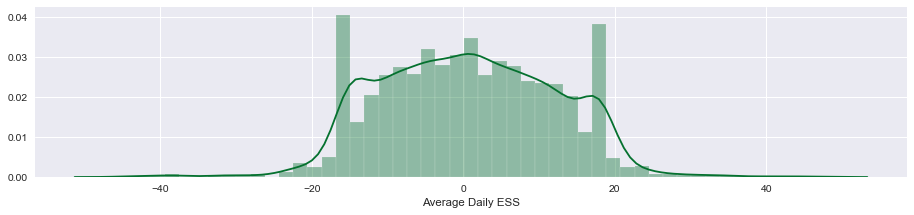

ValueError: cannot convert float NaN to integer

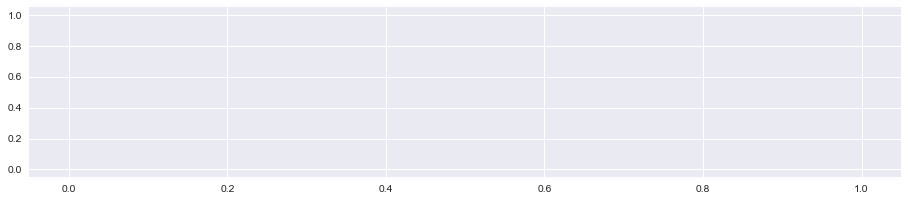

In [15]:
for k, v in plot_objects.items():
    sns.distplot(v, axlabel=k)
    plt.savefig("eda_figures/crude_oil/{}.png".format(k.replace(" ", "_")))
    plt.grid(True)
    plt.show()

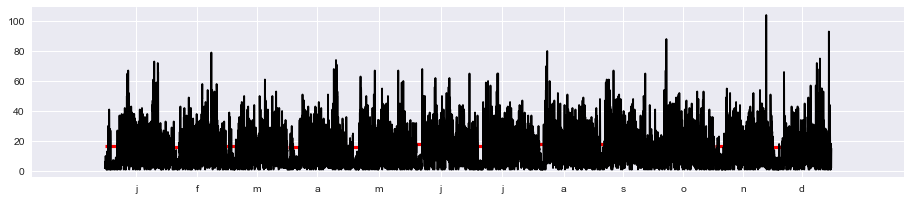

In [16]:
sm.tsa.graphics.month_plot(daily["NUM_EVENTS"].values, dates=daily.index)
plt.show()

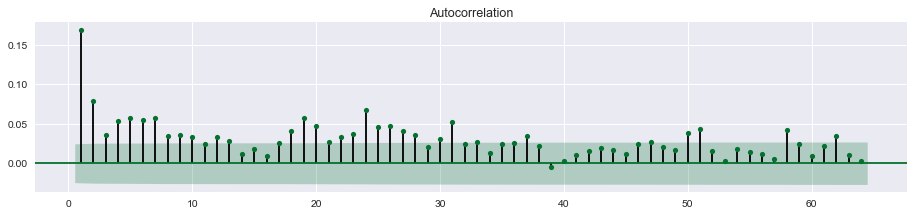

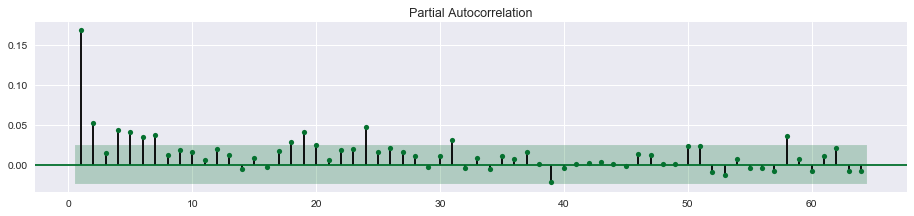

In [18]:
series = daily.ESS_MEAN
sm.tsa.graphics.plot_acf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("ACF_MEAN_ESS_L30"))
plt.show()
sm.tsa.graphics.plot_pacf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("PACF_MEAN_ESS_L30"))
plt.show()

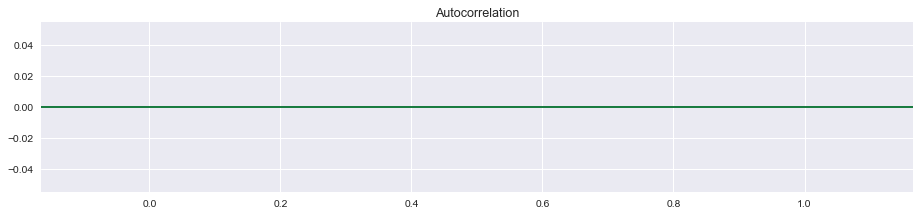

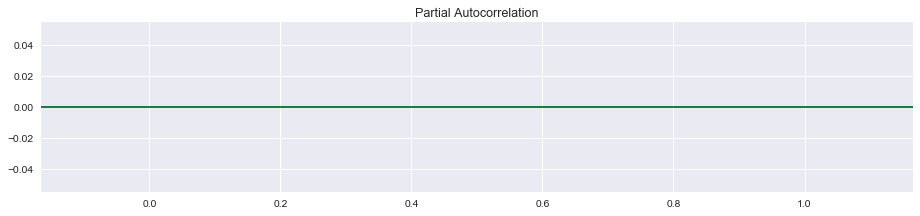

In [20]:
series = np.log(daily.ESS_TOTAL).diff().dropna()
sm.tsa.graphics.plot_acf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("ACF_MEAN_ESS_L30"))
plt.show()
sm.tsa.graphics.plot_pacf(series, lags=64, zero=False)
# plt.savefig("eda_figures/crude_oil/{}.png".format("PACF_MEAN_ESS_L30"))
plt.show()

In [21]:
day_counts = daily.groupby(daily.index.day_name())["NUM_EVENTS"].sum()

In [22]:
day_counts = pd.DataFrame(day_counts)
day_counts["DAY"] = day_counts.index
day_counts

,NUM_EVENTS,DAY
DATE,,
Friday,14517,Friday
Monday,17544,Monday
Saturday,657,Saturday
Sunday,4007,Sunday
Thursday,19952,Thursday
Tuesday,21493,Tuesday
Wednesday,28790,Wednesday


<Figure size 750x375 with 0 Axes>

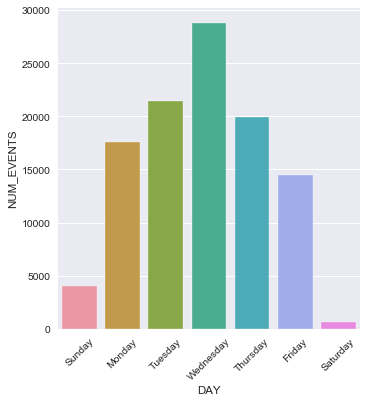

In [23]:
plt.rcParams["figure.dpi"] = 75
plt.figure(figsize=(10,5))
chart = sns.catplot(x="DAY", y="NUM_EVENTS", kind="bar",
            data=day_counts,
            order=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
chart.set_xticklabels(rotation=45)
# chart.savefig("eda_figures/crude_oil/{}.png".format("Count_Days"))
plt.show()

# With Oil Price

In [24]:
wti = pd.read_csv(
    "../data/ready_to_use/DCOILWTICO_FILLED.csv",
    index_col=0,
    header=0,
    parse_dates=["DATE"],
    date_parser=lambda d: datetime.strptime(d, "%Y-%m-%d")
)

In [25]:
d1 = np.sign(wti.diff().dropna())
d1 = d1.astype(np.int32)
d1.info()
d2 = pd.DataFrame(daily["WESS_MEAN"] >= 0)
d2 = d2[np.logical_and(d2.index >= datetime(2000,1,4), d2.index <= datetime(2019,9,30))]
d2 = d2.astype(np.int32)
d2.info()
a1 = d1.values.squeeze()
a2 = d2.values.squeeze()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5150 entries, 2000-01-04 to 2019-09-30
Data columns (total 1 columns):
DCOILWTICO    5150 non-null int32
dtypes: int32(1)
memory usage: 60.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6309 entries, 2000-01-04 to 2019-09-30
Data columns (total 1 columns):
WESS_MEAN    6309 non-null int32
dtypes: int32(1)
memory usage: 73.9 KB


In [27]:
d1 = daily["ESS_MEAN"]
d2 = wti.diff()["DCOILWTICO"]
idx = d1.index.intersection(d2.index)
idx = idx[-128:-32]

from sklearn.preprocessing import MinMaxScaler, StandardScaler
def squeeze(array):
    scaler = StandardScaler((-1, 1))
    return scaler.fit_transform(array)
a1 = squeeze(d1[idx].values.reshape(-1, 1))
a2 = squeeze(d2[idx].values.reshape(-1, 1))

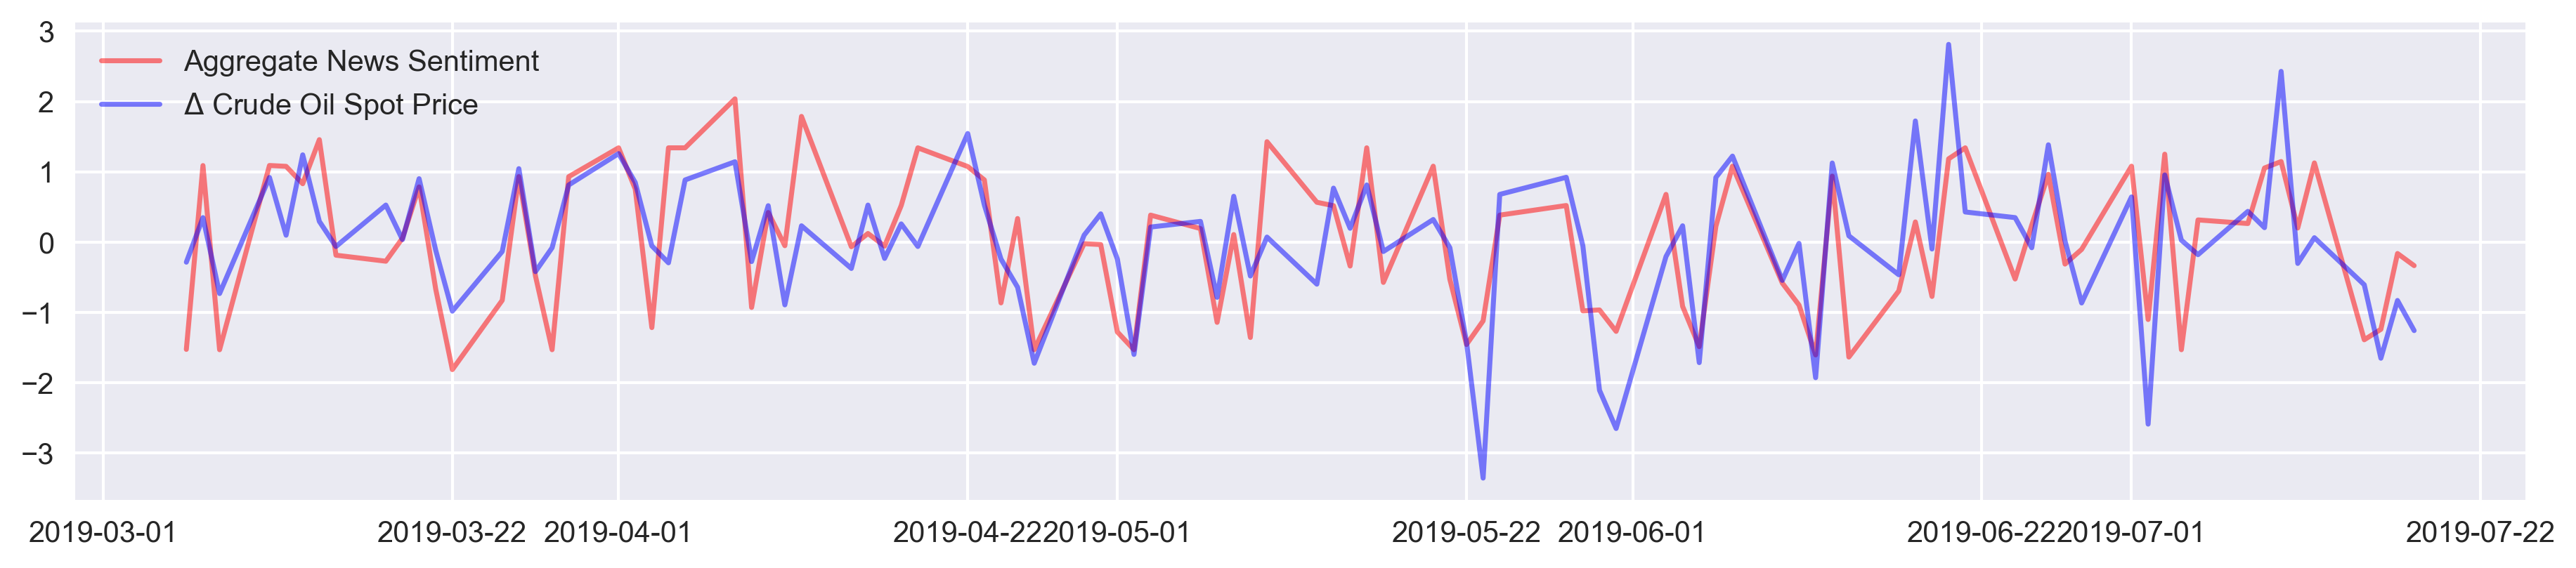

In [31]:
plt.rcParams["figure.dpi"] = 300
plt.plot(idx, a1, color="r", linewidth=1.7, alpha=0.5, label="Aggregate News Sentiment")
plt.plot(idx, a2, color="b", linewidth=1.7, alpha=0.5, label="$\Delta$ Crude Oil Spot Price")
plt.legend()
plt.grid(True)
plt.savefig("../figures/price_ess_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
print(stats.spearmanr(a1, a2))

SpearmanrResult(correlation=0.7005539255234282, pvalue=1.9450373876698747e-15)
